In [1]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import copy
import random
import multiprocessing as mp
from torch_geometric.data import HeteroData
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
!export CUDA_LAUNCH_BLOCKING=1


In [3]:
# Enable CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# torch.cuda.set_device(1)  # Use GPU 1

# # Verify that the correct GPU is being used
# if torch.cuda.is_available():
#     current_device = torch.cuda.current_device()
#     print(f"Using GPU: {torch.cuda.get_device_name(current_device)}")
#     print(f"Device ID: {current_device}")

In [5]:
# Load node features
s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/Zero_Features_Nodes/ChemBERTA_SMILES_SciBERT_DK_0_emb_183 .csv', index_col=0)  # Substrates CSV file
proteins_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/p_emb_full_237197.csv', index_col=0)  # Combined proteins CSV file


In [6]:
s_df

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
ChEBI ID,,,,,,,,,,,,,,,,,,,,,
CHEBI:30616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEBI:64837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEBI:58245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEBI:57673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEBI:58115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEBI:17821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEBI:16708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEBI:16040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Load edges
tp_s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_tp_s_edges_full.csv')
ppi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ppi_edges_full.csv')
ssi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ssi_edges_full.csv')

In [8]:
# Inspect and clean the data
def inspect_and_clean(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns: {non_numeric_columns}")
    if len(non_numeric_columns) > 0:
        df[non_numeric_columns] = df[non_numeric_columns].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(0)
    return df

In [9]:
s_df = inspect_and_clean(s_df)
proteins_df = inspect_and_clean(proteins_df)

Non-numeric columns: Index([], dtype='object')
Non-numeric columns: Index([], dtype='object')


In [10]:
# Convert features to numpy arrays
s_features = s_df.values
p_features = proteins_df.values

In [11]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (183, 1536), no KD (212, 768)
print(f"p_features shape: {p_features.shape}")  # Expected (some number, 2048), no KD (571609, 1280)

s_features shape: (183, 1536)
p_features shape: (237197, 2048)


In [12]:
# # Use GPU 1
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Device: {device}")

In [13]:
# Normalize features (normalizes columns to have mean 0 and variance 1)
# s_features = (s_features - np.mean(s_features, axis=0)) / np.std(s_features, axis=0)
p_features = (p_features - np.mean(p_features, axis=0)) / np.std(p_features, axis=0)

In [14]:
# Define the transformation layers, changes the number of features 1536 -> 2048
# for substrates and 2048 -> 2048 for proteins. The transform_p layer is useful 
# for transforming the feature representation within the same dimensional space,
#  y = Wx + b.

device = torch.device('cpu')  # Temporarily switch to CPU


transform_s = Linear(1536, 2048).to(device) # Change depending on the number of features
transform_p = Linear(2048, 2048).to(device)

In [15]:
# Apply transformations in batches, this can be useful when dealing with large 
# datasets that may not fit into memory or GPU all at once. 
def transform_in_batches(features, transform_layer, batch_size=10000):
    num_samples = features.shape[0]
    print(f"Number of samples: {num_samples}")
    transformed_features = []
    for i in range(0, num_samples, batch_size):
        batch = features[i:i + batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float).to(device)
        transformed_batch = transform_layer(batch_tensor)
        transformed_features.append(transformed_batch.detach().cpu().numpy())  # Use detach() before numpy()
    return np.vstack(transformed_features) # Stack arrays in sequence vertically (row wise)


In [16]:
s_features_transformed = transform_in_batches(s_features, transform_s)
p_features_transformed = transform_in_batches(p_features, transform_p)


Number of samples: 183
Number of samples: 237197


In [17]:
# Convert back to tensors
s_features_tensor = torch.tensor(s_features_transformed, dtype=torch.float).to(device)
p_features_tensor = torch.tensor(p_features_transformed, dtype=torch.float).to(device)


In [18]:
# Combine features, vertically stacks features (dim=0) to create a single tensor
all_features = torch.cat([p_features_tensor, s_features_tensor], dim=0)


In [19]:
protein_ids = set(proteins_df.index)
substrate_ids = set(s_df.index)

In [20]:
# num_cores = 64

In [21]:
# def generate_negative_edges_chunk(chunk, possible_sources, possible_targets, existing_edges):
#     negative_edges = []
#     for _ in chunk:
#         while True:
#             source = random.choice(possible_sources)
#             target = random.choice(possible_targets)
#             if (source, target) not in existing_edges and (target, source) not in existing_edges:
#                 negative_edges.append((source, target))
#                 break
#     return negative_edges

In [22]:
# def generate_negative_edges(df, possible_sources, possible_targets, num_cores, chunk_size=10000):
#     existing_edges = set(zip(df['source'], df['target']))

#     # Create chunks
#     chunks = [range(i, min(i + chunk_size, len(df))) for i in range(0, len(df), chunk_size)]
    
#     with mp.Pool(num_cores) as pool:
#         results = pool.starmap(
#             generate_negative_edges_chunk,
#             [(chunk, possible_sources, possible_targets, existing_edges) for chunk in chunks]
#         )

#     # Flatten the list of lists
#     negative_edges = [edge for sublist in results for edge in sublist]
#     negative_df = pd.DataFrame(negative_edges, columns=['source', 'target'])
#     return negative_df


In [23]:
# # Generate negative edges for PPI
# ppi_neg_df = generate_negative_edges(ppi_df, protein_ids, protein_ids, num_cores)
# ppi_neg_df.to_csv('/data/servilla/DT_HGNN/Edges/negative_ppi_edges.csv')

In [24]:
# # Generate negative edges for SSI
# ssi_neg_df = generate_negative_edges(ssi_df, substrate_ids, substrate_ids, num_cores)
# ssi_neg_df.to_csv('/data/servilla/DT_HGNN/Edges/negative_ssi_edges.csv')

In [25]:
# # Generate negative edges for TP_S
# tp_s_neg_df = generate_negative_edges(tp_s_df, protein_ids, substrate_ids, num_cores)
# tp_s_neg_df.to_csv('/data/servilla/DT_HGNN/Edges/negative_tp_s_edges.csv')

In [26]:
# # Load negative edges
# ppi_neg_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/Negative_Edges/negative_ppi_edges.csv', index_col=0)
# ssi_neg_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/Negative_Edges/negative_ssi_edges.csv', index_col=0)
# tp_s_neg_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/Negative_Edges/negative_tp_s_edges.csv', index_col=0)

In [27]:
# def concatenate_edges(pos_df, neg_df):
#     # Add a label column to indicate positive (1) or negative (0) edges
#     pos_df['label'] = 1
#     neg_df['label'] = 0

#     # Concatenate the positive and negative edges
#     combined_df = pd.concat([pos_df, neg_df], ignore_index=True)
#     return combined_df

In [28]:
# # Concatenate edges for each type
# ppi_combined_df = concatenate_edges(ppi_df, ppi_neg_df)
# ssi_combined_df = concatenate_edges(ssi_df, ssi_neg_df)
# tp_s_combined_df = concatenate_edges(tp_s_df, tp_s_neg_df)

In [29]:
# # Save the combined dataframes to CSV files
# ppi_combined_df.to_csv('/data/servilla/DT_HGNN/Edges/combined_ppi_edges.csv', index=False)
# ssi_combined_df.to_csv('/data/servilla/DT_HGNN/Edges/combined_ssi_edges.csv', index=False)
# tp_s_combined_df.to_csv('/data/servilla/DT_HGNN/Edges/combined_tp_s_edges.csv', index=False)

In [30]:
# # Load the combined edges
# ppi_combined_df = pd.read_csv('/data/servilla/DT_HGNN//Model/Edges/Combined_Edges/combined_ppi_edges.csv')
# ssi_combined_df = pd.read_csv('/data/servilla/DT_HGNN//Model/Edges/Combined_Edges/combined_ssi_edges.csv')
# tp_s_combined_df = pd.read_csv('/data/servilla/DT_HGNN//Model/Edges/Combined_Edges/combined_tp_s_edges.csv')


In [31]:
def split_data(df, train_size=0.8, val_size=0.1, test_size=0.1):
    # Split into train and temp (80% train, 20% temp)
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # Calculate the size for validation and test splits
    val_test_ratio = val_size / (val_size + test_size)  # 50% of temp goes to validation and 50% to test

    # Split temp into validation and test (10% each)
    val_df, test_df = train_test_split(temp_df, train_size=val_test_ratio, random_state=42)
    
    return train_df, val_df, test_df

In [32]:
# Split data for each edge type
ppi_train_df, ppi_val_df, ppi_test_df = split_data(ppi_df)
ssi_train_df, ssi_val_df, ssi_test_df = split_data(ssi_df)
tp_s_train_df, tp_s_val_df, tp_s_test_df = split_data(tp_s_df)

In [33]:
tp_s_train_df

,source,target,label
22326,Q8A7Z7,CHEBI:17748,0
24868,B4SKV8,CHEBI:64615,0
15236,Q2RNR2,CHEBI:77016,0
20396,P59914,CHEBI:33019,0
20230,B1XWC5,CHEBI:58608,0
...,...,...,...
21575,Q9HGM6,CHEBI:29036,0
5390,P0A437,CHEBI:16813,1
860,Q1I7Z8,CHEBI:132124,1
15795,A0KNY4,CHEBI:83228,0


In [34]:
# Create separate mappings
protein_mapping = {node_id: i for i, node_id in enumerate(proteins_df.index)}
substrate_mapping = {node_id: i for i, node_id in enumerate(s_df.index)}

# Helper function to apply the correct mapping
def apply_correct_mapping(df, source_mapping, target_mapping):
    df['source'] = df['source'].map(source_mapping)
    df['target'] = df['target'].map(target_mapping)
    df.dropna(inplace=True)
    return df

# Apply the correct mappings
tp_s_train_df = apply_correct_mapping(tp_s_train_df, protein_mapping, substrate_mapping)
tp_s_val_df = apply_correct_mapping(tp_s_val_df, protein_mapping, substrate_mapping)
tp_s_test_df = apply_correct_mapping(tp_s_test_df, protein_mapping, substrate_mapping)

ppi_train_df = apply_correct_mapping(ppi_train_df, protein_mapping, protein_mapping)
ppi_val_df = apply_correct_mapping(ppi_val_df, protein_mapping, protein_mapping)
ppi_test_df = apply_correct_mapping(ppi_test_df, protein_mapping, protein_mapping)

ssi_train_df = apply_correct_mapping(ssi_train_df, substrate_mapping, substrate_mapping)
ssi_val_df = apply_correct_mapping(ssi_val_df, substrate_mapping, substrate_mapping)
ssi_test_df = apply_correct_mapping(ssi_test_df, substrate_mapping, substrate_mapping)


In [35]:
# Create edge index tensors
train_edges_tp_s = torch.tensor(tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_tp_s = torch.tensor(tp_s_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_tp_s = torch.tensor(tp_s_test_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ppi = torch.tensor(ppi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ppi = torch.tensor(ppi_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_ppi = torch.tensor(ppi_test_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ssi = torch.tensor(ssi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ssi = torch.tensor(ssi_val_df[['source', 'target']].values.T, dtype=torch.long)
test_edges_ssi = torch.tensor(ssi_test_df[['source', 'target']].values.T, dtype=torch.long)

# Convert the labels to tensors
train_labels_tp_s = torch.tensor(tp_s_train_df['label'].values, dtype=torch.float)
val_labels_tp_s = torch.tensor(tp_s_val_df['label'].values, dtype=torch.float)
test_labels_tp_s = torch.tensor(tp_s_test_df['label'].values, dtype=torch.float)

train_labels_ppi = torch.tensor(ppi_train_df['label'].values, dtype=torch.float)
val_labels_ppi = torch.tensor(ppi_val_df['label'].values, dtype=torch.float)
test_labels_ppi = torch.tensor(ppi_test_df['label'].values, dtype=torch.float)

train_labels_ssi = torch.tensor(ssi_train_df['label'].values, dtype=torch.float)
val_labels_ssi = torch.tensor(ssi_val_df['label'].values, dtype=torch.float)
test_labels_ssi = torch.tensor(ssi_test_df['label'].values, dtype=torch.float)


In [36]:
positive_tp_s_train_df = tp_s_train_df[tp_s_train_df['label'] == 1]

train_edges_tp_s_positive = torch.tensor(positive_tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ppi_train_df = ppi_train_df[ppi_train_df['label'] == 1]

train_edges_ppi_positive = torch.tensor(positive_ppi_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ssi_train_df = ssi_train_df[ssi_train_df['label'] == 1]

train_edges_ssi_positive = torch.tensor(positive_ssi_train_df[['source', 'target']].values.T, dtype=torch.long)

In [37]:
data = HeteroData()

# Assign node features
data['protein'].x = p_features_tensor
data['substrate'].x = s_features_tensor

# Assign training edges
data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s_positive #train_edges_tp_s 
data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi_positive #train_edges_ppi 
data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi_positive #train_edges_ssi 


In [38]:
p_features_tensor

tensor([[-0.1119,  0.1574, -0.2022,  ..., -0.7306,  0.3428, -0.6092],
        [ 0.0325,  0.1157,  0.0050,  ...,  0.3011,  0.1321, -0.0125],
        [-0.0024,  0.9144,  0.4285,  ...,  0.2823, -0.1097, -0.2799],
        ...,
        [ 1.2817, -0.1124,  0.2220,  ..., -0.1969,  0.0500,  0.4711],
        [ 1.6778,  0.3059,  0.1612,  ..., -0.4729, -0.3490, -0.2921],
        [ 0.7275,  1.1794, -0.0652,  ...,  0.3410,  0.7209,  0.6526]])

Epoch 1, Train Loss: 0.6954, Validation Loss: 0.6863, Val Accuracy: 0.6057, Precision: 0.7206, Recall: 0.3443, F1: 0.4660, AUC: 0.6348, LR: 0.0001
Epoch 2, Train Loss: 0.6860, Validation Loss: 0.6775, Val Accuracy: 0.6900, Precision: 0.7868, Recall: 0.5206, F1: 0.6266, AUC: 0.7414, LR: 0.0001
Epoch 3, Train Loss: 0.6768, Validation Loss: 0.6687, Val Accuracy: 0.7672, Precision: 0.8230, Recall: 0.6804, F1: 0.7450, AUC: 0.8129, LR: 0.0001
Epoch 4, Train Loss: 0.6679, Validation Loss: 0.6602, Val Accuracy: 0.8111, Precision: 0.8351, Recall: 0.7749, F1: 0.8039, AUC: 0.8554, LR: 0.0001
Epoch 5, Train Loss: 0.6591, Validation Loss: 0.6517, Val Accuracy: 0.8298, Precision: 0.8337, Recall: 0.8237, F1: 0.8287, AUC: 0.8826, LR: 0.0001
Epoch 6, Train Loss: 0.6504, Validation Loss: 0.6433, Val Accuracy: 0.8426, Precision: 0.8320, Recall: 0.8582, F1: 0.8449, AUC: 0.9013, LR: 0.0001
Epoch 7, Train Loss: 0.6419, Validation Loss: 0.6351, Val Accuracy: 0.8504, Precision: 0.8279, Recall: 0.8845, F1: 0.8

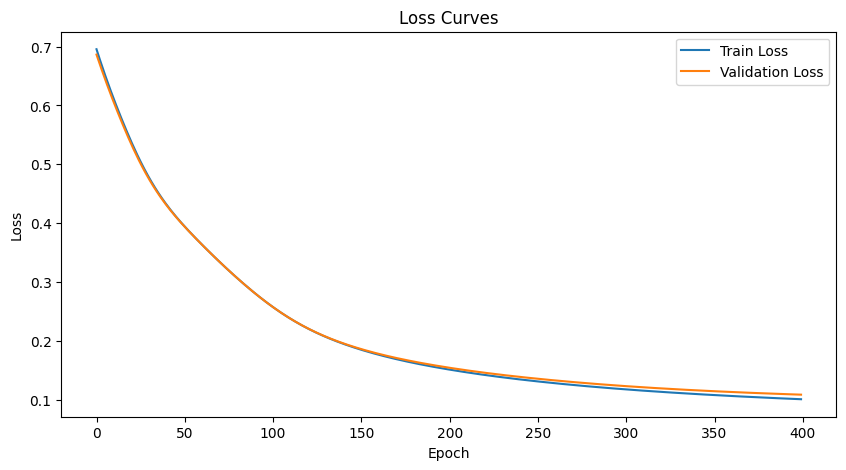

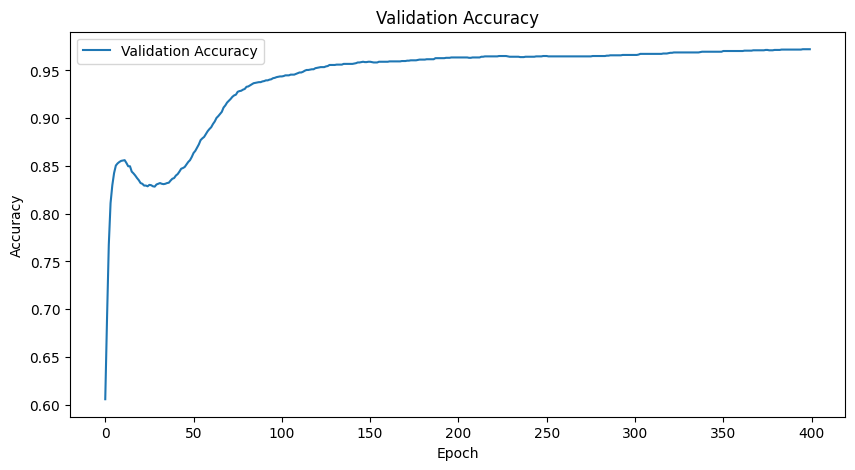

In [39]:
# data = HeteroData()

# # Assign node features
# data['protein'].x = p_features_tensor
# data['substrate'].x = s_features_tensor

# # Assign training edges
# data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s
# data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi
# data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi



# Initialize the model
class GCNLinkPredictor(nn.Module):
    def __init__(self, protein_dim, substrate_dim, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        self.protein_conv1 = GCNConv(protein_dim, hidden_channels)
        self.substrate_conv1 = GCNConv(substrate_dim, hidden_channels)
        self.protein_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.substrate_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.link_predictor = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def encode(self, x_dict, edge_index_dict):
        z_protein = self.protein_conv1(x_dict['protein'], edge_index_dict[('protein', 'interacts_with', 'protein')])
        z_substrate = self.substrate_conv1(x_dict['substrate'], edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        return z_protein, z_substrate

    def forward(self, x_dict, edge_index_dict, edges):
        z_protein, z_substrate = self.encode(x_dict, edge_index_dict)
        z_combined = torch.cat([z_protein[edges[0]], z_substrate[edges[1]]], dim=-1)
        return self.link_predictor(z_combined).squeeze()

# Initialize the model
model = GCNLinkPredictor(protein_dim=2048, substrate_dim=2048, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)


# Assuming `data` contains x_dict and edge_index_dict
x_dict = data.x_dict
edge_index_dict = data.edge_index_dict


# Update the train, validate, and test functions to return predictions
def train(x_dict, edge_index_dict, train_edges_tp_s, train_labels_tp_s): 
    model.train()
    optimizer.zero_grad()
    out = model(x_dict, edge_index_dict, train_edges_tp_s)
    loss = criterion(out, train_labels_tp_s)
    loss.backward()
    optimizer.step()

    return loss.item(), out.detach()

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict, val_edges_tp_s)
        loss = criterion(out, val_labels_tp_s)
    return loss.item(), out

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict, test_edges_tp_s)
        loss = criterion(out, test_labels_tp_s)
    return loss.item(), out

# Calculate additional metrics
def calculate_metrics(labels, preds):
    preds = torch.sigmoid(preds).cpu().numpy()
    preds_binary = (preds > 0.5).astype(int)
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels, preds_binary)
    precision = precision_score(labels, preds_binary)
    recall = recall_score(labels, preds_binary)
    f1 = f1_score(labels, preds_binary)
    auc = roc_auc_score(labels, preds)

    return accuracy, precision, recall, f1, auc

# Modify the training loop to include metric calculation and visualization
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
epochs = 400
for epoch in range(epochs):
    # Training step
    train_loss, train_preds = train(x_dict, edge_index_dict, train_edges_tp_s, train_labels_tp_s)
    # Validation step
    val_loss, val_preds = validate()

    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate validation metrics
    accuracy, precision, recall, f1, auc = calculate_metrics(val_labels_tp_s, val_preds)
    val_accuracies.append(accuracy)

    # Print metrics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1: {f1:.4f}, AUC: {auc:.4f}, LR: {scheduler.get_last_lr()[0]}")

    # Step the LR scheduler
    scheduler.step(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), '/data/servilla/DT_HGNN/data/Models_saves/best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load the best model
model.load_state_dict(torch.load('/data/servilla/DT_HGNN/data/Models_saves/best_model.pth'))

# Testing
test_loss, test_preds = test()
test_accuracy, test_precision, test_recall, test_f1, test_auc = calculate_metrics(test_labels_tp_s, test_preds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, AUC: {test_auc:.4f}")

# Step 4: Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.show()

# Step 5: Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()
